In [2]:
import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np
import random

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [3]:
import torch
import torch.nn.functional as F
import math

def nearest_power_of_two(x: int, round_up: bool = False) -> int:
    return (
        1 << math.floor(math.log2(x)) if not round_up else 1 << math.ceil(math.log2(x))
    )

def convolve(u: torch.Tensor, v: torch.Tensor, n: int, use_approx: bool = True) -> tuple[torch.Tensor, torch.Tensor]:
    # print(u.shape, v.shape)
    bsz, seq_len, d_in = u.shape

    sgn = torch.full((1, seq_len, 1), 1, device=u.device)
    sgn[:, 1::2] *= -1

    _, K = v.shape
    sgn = sgn.unsqueeze(-1)
    v = v.view(1, -1, K, 1, 1).to(torch.float32) # (bsz, seq_len, K, d_in, stack)
    u = u.view(bsz, -1, 1, d_in).expand(bsz, -1, K, d_in)

    v = torch.fft.rfft(v, n=n, dim=1)
    U = torch.stack([u, u * sgn], dim=-1).to(torch.float32)
    U = torch.fft.rfft(U, n=n, dim=1)
    U_conv = torch.fft.irfft(v * U, n=n, dim=1)[:, :seq_len]
    U_plus, U_minus = torch.unbind(U_conv, dim=-1)
    U_minus = U_minus * sgn

    return U_plus, U_minus

In [4]:
def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int,
    K: int,
    use_hankel_L: bool = False,
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


In [5]:
def filter_pre_init(filter_cnt, seq_len):
    t = torch.linspace(0, 2 * math.pi, seq_len).unsqueeze(1)
    offsets = torch.rand(1, filter_cnt) * 2 * math.pi
    decay = torch.exp(-torch.linspace(0, 2, seq_len)).unsqueeze(1)
    filters = torch.sin(t + offsets) * decay

    return filters.to(device) /100

In [6]:
class Sin3Filter(nn.Module):
    def __init__(self, filter_cnt, seq_len):
        super().__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len

        self.amplitude = nn.Parameter(torch.randn(filter_cnt).to(device) / 100)
        self.frequency1 = nn.Parameter(torch.randn(filter_cnt).to(device)/seq_len)
        self.phase1 = nn.Parameter(torch.randn(filter_cnt).to(device))
        self.frequency2 = nn.Parameter(torch.randn(filter_cnt).to(device))
        self.phase2 = nn.Parameter(torch.randn(filter_cnt).to(device)/seq_len)
        self.frequency3 = nn.Parameter(torch.randn(filter_cnt).to(device))
        self.phase3 = nn.Parameter(torch.randn(filter_cnt).to(device)/seq_len)
        self.decay = nn.Parameter(4* torch.ones(filter_cnt).to(device))

    def forward(self):
        points = torch.arange(self.seq_len, device=device).float().unsqueeze(0) / self.seq_len

        sine1 = torch.cos(2 * torch.pi * self.frequency1.unsqueeze(1) * points + self.phase1.unsqueeze(1))
        sine2 = torch.cos(2 * torch.pi * self.frequency2.unsqueeze(1) * points + self.phase2.unsqueeze(1))
        sine3 = torch.cos(2 * torch.pi * self.frequency3.unsqueeze(1) * points + self.phase3.unsqueeze(1))


        product_of_sines = self.amplitude.unsqueeze(1) * sine1 * sine2 * sine3
        decay_values = torch.exp(1-self.decay.unsqueeze(1) * points)
        filtered_values = product_of_sines * decay_values
        return filtered_values

In [7]:
class GaussianFilter(nn.Module):
    def __init__(self, filter_cnt, seq_len):
        super().__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len
        # Parameters for Gaussian
        self.means = nn.Parameter(torch.randn(filter_cnt).to(device)/seq_len)
        self.variances = nn.Parameter(torch.randn(filter_cnt).to(device)/seq_len)
        self.coeffs = nn.Parameter(torch.randn(filter_cnt).to(device))

    def forward(self):
        points = torch.arange(self.seq_len, device=device).float().unsqueeze(0)/self.seq_len
        # Gaussian
        gaussian_values = torch.exp(-((points - self.means.unsqueeze(1))**2) / (2* torch.abs(self.variances.unsqueeze(1))))

        filtered_values = gaussian_values * self.coeffs.unsqueeze(1)
        return filtered_values

In [8]:
class PolyFilter(nn.Module):
    def __init__(self, filter_cnt, seq_len):
        super().__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len
        self.decay = nn.Parameter(4*torch.ones(filter_cnt).to(device))
        self.poly_coeffs = nn.Parameter(torch.randn(filter_cnt, 8).to(device)/100)

    def forward(self):

        points = torch.arange(self.seq_len, device=device).float().unsqueeze(0)
        points/=self.seq_len
        polynomial_values = torch.zeros(self.filter_cnt, self.seq_len, device=device)
        for i in range(8):
            polynomial_values += self.poly_coeffs[:, i].unsqueeze(1) * (points ** (7 - i))

        decay_values = torch.exp(1-self.decay.unsqueeze(1) * points)
        filtered_values = polynomial_values * decay_values

        return filtered_values

In [9]:
class SinFilter(nn.Module):
    def __init__(self, filter_cnt, seq_len):
        super().__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len

        self.amplitude = nn.Parameter(torch.randn(filter_cnt).to(device) / 100)
        self.frequency = nn.Parameter(torch.randn(filter_cnt).to(device))
        self.phase = nn.Parameter(torch.randn(filter_cnt).to(device)/seq_len)
        self.decay = nn.Parameter(4*torch.ones(filter_cnt).to(device))

    def forward(self):
        points = torch.arange(self.seq_len, device=device).float().unsqueeze(0) / self.seq_len
        sinusoidal_values = self.amplitude.unsqueeze(1) * torch.cos(
            2 * torch.pi * self.frequency.unsqueeze(1) * points + self.phase.unsqueeze(1)
        )
        decay_values = torch.exp(1-self.decay.unsqueeze(1) * points)
        filtered_values = sinusoidal_values * decay_values

        return filtered_values

In [11]:
class DefaultFilter(nn.Module):
    def __init__(self, filter_cnt, seq_len):
        super(DefaultFilter, self).__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len
        self.filters = nn.Parameter(filter_pre_init(filter_cnt, seq_len))

    def forward(self):
        return self.filters

In [12]:
class NNFilter(nn.Module):
    def __init__(self, filter_cnt, seq_len, hidden_size=64):
        super().__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len
        self.hidden_size = hidden_size

        self.networks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.ReLU(),
                nn.Linear(self.hidden_size, 1),
                nn.Tanh()
            ) for _ in range(filter_cnt)
        ]).to(device)

        self.decay_params = nn.Parameter(torch.full((filter_cnt,), 1.0)).to(device)

    def forward(self):
        input_seq = torch.arange(0, self.seq_len, dtype=torch.float32) / self.seq_len
        input_seq = input_seq.view(-1, 1).to(device)

        outputs = torch.stack([
            network(input_seq).squeeze(-1) * torch.exp(-self.decay_params[i] * input_seq.squeeze(-1)) / 10
            for i, network in enumerate(self.networks)
        ])

        return outputs

In [13]:
class Filter(nn.Module):
    def __init__(self, filter_cnt, seq_len):
        super().__init__()
        self.filter_cnt = filter_cnt
        self.seq_len = seq_len
        self.sin3_filter = Sin3Filter(filter_cnt//3, seq_len)
        self.sin_filter = SinFilter(filter_cnt//3, seq_len)
        self.poly_filter = NNFilter(filter_cnt//3, seq_len)

    def forward(self):
      filters = torch.cat([self.sin3_filter(), self.sin_filter(), self.poly_filter()], dim=0)
      return filters
      # return torch.flip(filters, dims=[1])

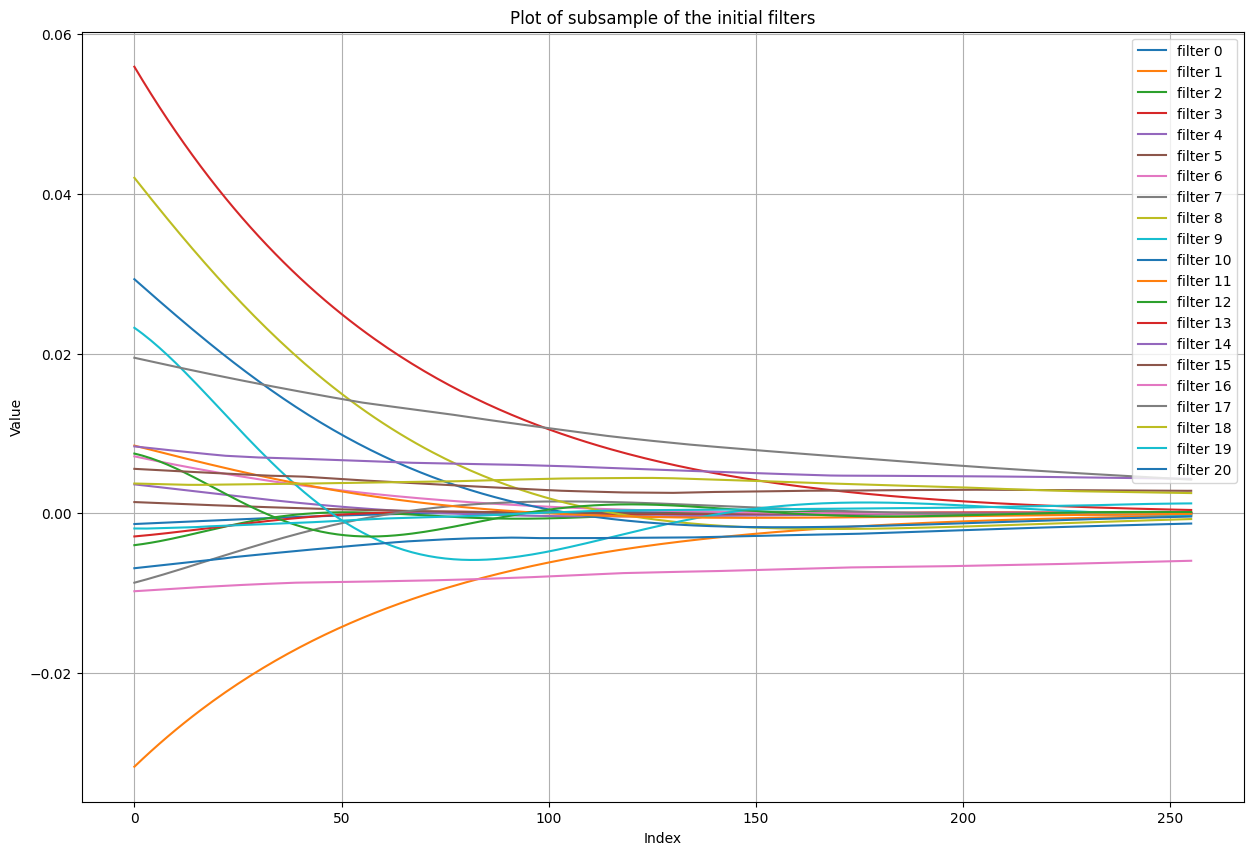

In [17]:
import matplotlib.pyplot as plt
def_filters = Filter(21,  256)

plt.figure(figsize=(15, 10))
for i in range(21):
	plt.plot(def_filters()[i, :].cpu().detach().numpy(), label=f'filter {i}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of subsample of the initial filters')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class LearnedFilters(nn.Module):
    def __init__(self, config, phi) -> None:
        super(LearnedFilters, self).__init__()
        self.config = config
        self.adaptive_filters = Filter(config['num_eigh'], config['seq_len'])
        self.n = nearest_power_of_two(config['seq_len'] * 2 - 1, round_up=True)
        self.K = config['num_eigh'] + config['num_fixed_filters']
        self.d_in = config['d_in']
        self.d_out = config['d_out']
        self.use_hankel_L = config['use_hankel_L']
        self.use_approx = False
        self.fixed_filters = config['fixed_filters']
        self.num_ff = config['num_fixed_filters']



        self.task = config['task_count']

        self.M_phi_plus = nn.Parameter(
            torch.randn(self.task, self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / self.K
        )

        self.M_phi_minus = nn.Parameter(
            torch.randn(self.task, self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / self.K
        )

    def forward(self, task_list: list[int], x: torch.Tensor) -> torch.Tensor:
        if self.num_ff == 0:
          phi = self.adaptive_filters().T
        else:
          phi = torch.concat([self.adaptive_filters().T, self.fixed_filters],dim = -1)
        U_plus, U_minus = convolve(x, phi, self.n, False)
        # print(U_plus.shape)
        spectral_plus = torch.einsum('bijl,bjlm->bim', U_plus, self.M_phi_plus[task_list])
        spectral_minus = torch.einsum('bijl,bjlm->bim', U_minus, self.M_phi_plus[task_list])
        return spectral_plus if self.use_hankel_L else spectral_plus + spectral_minus

    def loss(self, inputs, targets, task_list):
        pred = self.forward(task_list, inputs)
        # print(pred.shape, targets.shape)
        loss = F.mse_loss(pred, targets)
        return  loss



In [ ]:
def min_eigenvalue_batch(matrices: torch.Tensor) -> list:
    min_eigenvalues = []
    for matrix in matrices:
        eigenvalues = torch.linalg.eigvals(matrix)
        min_eigenvalue = torch.min(torch.abs(eigenvalues)).item()
        min_eigenvalues.append(min_eigenvalue)
    return torch.Tensor(min_eigenvalues)

In [ ]:
def max_eigenvalue_batch(matrices: torch.Tensor) -> list:
    max_eigenvalues = []
    for matrix in matrices:
        eigenvalues = torch.linalg.eigvals(matrix)
        max_eigenvalue = torch.max(torch.abs(eigenvalues)).item()
        max_eigenvalues.append(max_eigenvalue)
    return torch.Tensor(max_eigenvalues)

In [ ]:
import copy
class MultiLDS:
  def __init__(self, n_tasks: int, A: torch.tensor, B: torch.tensor, C: torch.tensor, D: torch.tensor, h0: torch.tensor):
    self.d_h = A.shape[-1]
    _, _, self.d_u = B.shape #task, d_h, d_u
    _, self.d_o, _ = C.shape
    self.A = A  # hidden state dynamics
    self.B = B  # hidden state dynamics
    self.C = C  # observation projection
    self.D = D  # observation projection
    self.h0 = h0  # initial hidden state
    # self.h = h0  # current hidden state
    self.n_tasks = n_tasks
    self.dtype = float

  def step(self, task_list: list[int], u: torch.tensor, h) -> torch.tensor:
    # print(self.A[task_list].device, self.B[task_list].device, u.device, h.device)
    h_next = self.A[task_list] @ h.unsqueeze(-1) + self.B[task_list] @ u.unsqueeze(-1)
    obs = self.C[task_list] @ h_next + self.D[task_list] @ u.unsqueeze(-1)
    return obs, h_next.reshape(h.shape)

  def generate_trajectory(self, task_list: list[int], us: torch.tensor) -> torch.tensor:
    h = self.h0[task_list].to(device)
    obs = []

    for i in range(us.shape[1]):
      step, h = self.step(task_list,us[:,i], h)
      obs.append(step)
    return torch.stack(obs, dim=1).squeeze(dim  =  -1)

  def sample(self, samples: list[int]): # returns indices of tasks for which to run training
    return np.choice(np.arange(self.tasks), size=samples)

def random_LDS(tasks: int, d_h: int, d_o: int, d_u: int, delta: float):
  """
  makes a random LDS with hidden state dimension d_h, observation dimension d_o, and control dimension d_u.
  `delta` is a float in [0, 1] such that ||A|| = 1 - delta.
  """

  A = torch.randn(tasks, d_h, d_h)/d_h
  m_evals=  max_eigenvalue_batch(A)
  A =  torch.stack([(1-delta) * A[i]/ m_evals[i] for i in range(tasks)]) #so max_eigenvalue is (1-delta)

  B = torch.rand(tasks, d_h, d_u) /d_u #torch.randn is normal distribution and leads to collapse  sometimes (idk why)
  C = torch.rand(tasks, d_o, d_h) / d_h
  D = torch.zeros(tasks, d_o, d_u)
  h0 = torch.zeros(tasks, d_h)
  return MultiLDS(tasks, A.to(device), B.to(device), C.to(device), D.to(device), h0)

In [83]:
seq_len = 256
num_eigh = 60 #must be multiple of 3 if 3 filter sets are used
num_fixed_filters = 0
use_hankel_L = True

phi= get_spectral_filters(seq_len = seq_len, K = num_fixed_filters,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)
d_h = 2
d_out = 1
d_in = 1
n_tasks = 50000

config = {
    "num_eigh": num_eigh,
    "num_fixed_filters": num_fixed_filters,
    "fixed_filters": phi,
    "use_hankel_L": True,
    "torch_dtype": torch.float32,
    "d_in": d_in,
    "d_out": d_out,
    "seq_len": seq_len,
    'task_count':n_tasks
}


multi_lds = random_LDS(tasks = n_tasks, d_h = d_h, d_o = d_out, d_u = d_in,delta =0.01)
print(multi_lds.A.shape)

<ipython-input-3-85f048c3cd96>:27: RuntimeWarning: invalid value encountered in power
  phi_k *= sigma_k ** 0.25


torch.Size([50000, 2, 2])


In [84]:
model = LearnedFilters(config, phi).to(device)


lr_adaptive_filters = 0.01
lr_other_params = 0.01


param_groups = [
    {'params': model.adaptive_filters, 'lr': 0},  # Initially set lr to 0 for adaptive filters
    {'params': [param for name, param in model.named_parameters() if name != 'adaptive_filters'], 'lr': lr_other_params}
]

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

batch_iterations = 10000
batch_size = 1000

for it in range(batch_iterations):
    if it == 300:

        optimizer.param_groups[0]['lr'] = lr_adaptive_filters

    inputs = torch.randn(batch_size, seq_len, d_in).to(device)  # fix inputs at each iteration

    task_list = random.sample(range(n_tasks), k=batch_size)
    targets = multi_lds.generate_trajectory(task_list=task_list, us=inputs)

    loss = model.loss(inputs, targets, task_list=task_list)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if it % 10 == 0:
        print(f"Step {it}: Loss = {loss.item()}")

model.eval()

Step 0: Loss = 3.5035343170166016
Step 10: Loss = 2.7077596187591553
Step 20: Loss = 3.811277389526367
Step 30: Loss = 3.939551591873169
Step 40: Loss = 3.88236665725708
Step 50: Loss = 3.8102645874023438
Step 60: Loss = 4.134937286376953
Step 70: Loss = 3.9942541122436523
Step 80: Loss = 3.196012020111084
Step 90: Loss = 2.908672571182251
Step 100: Loss = 3.199000120162964
Step 110: Loss = 3.905488967895508
Step 120: Loss = 2.961263656616211
Step 130: Loss = 4.926054954528809
Step 140: Loss = 4.4273505210876465
Step 150: Loss = 6.097170352935791
Step 160: Loss = 3.176281452178955
Step 170: Loss = 4.322227954864502
Step 180: Loss = 7.686859130859375
Step 190: Loss = 3.2994132041931152
Step 200: Loss = 2.88678240776062
Step 210: Loss = 2.1291329860687256
Step 220: Loss = 16.378944396972656
Step 230: Loss = 4.095164775848389
Step 240: Loss = 3.579157590866089
Step 250: Loss = 2.488497257232666
Step 260: Loss = 4.111186981201172
Step 270: Loss = 5.620534896850586
Step 280: Loss = 3.904356

KeyboardInterrupt: 

In [85]:
import matplotlib.pyplot as plt
arr = min_eigenvalue_batch(multi_lds.A.detach())
# plt.hist(arr, bins = 100)

In [86]:

random_input = torch.randn(1, seq_len, d_in).to(device)
lds_trajectory = multi_lds.generate_trajectory(task_list=[87], us=random_input)
with torch.no_grad():
    learned_filters_output = model.forward(task_list=[87], x=random_input)
lds_trajectory_list = lds_trajectory.cpu().numpy().tolist()
learned_filters_output_list = learned_filters_output.cpu().numpy().tolist()

mse = F.mse_loss(learned_filters_output, lds_trajectory).item()
mse

0.03431318700313568

In [87]:
lds_trajectory_mean = lds_trajectory.mean(dim=1, keepdim=True)
mse_mean_subtracted = F.mse_loss(lds_trajectory, lds_trajectory_mean)
mse_mean_subtracted.item()

<ipython-input-87-0eda46465bce>:2: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_mean_subtracted = F.mse_loss(lds_trajectory, lds_trajectory_mean)


0.04497168958187103

In [88]:
learned_filters_output.shape

torch.Size([1, 256, 1])

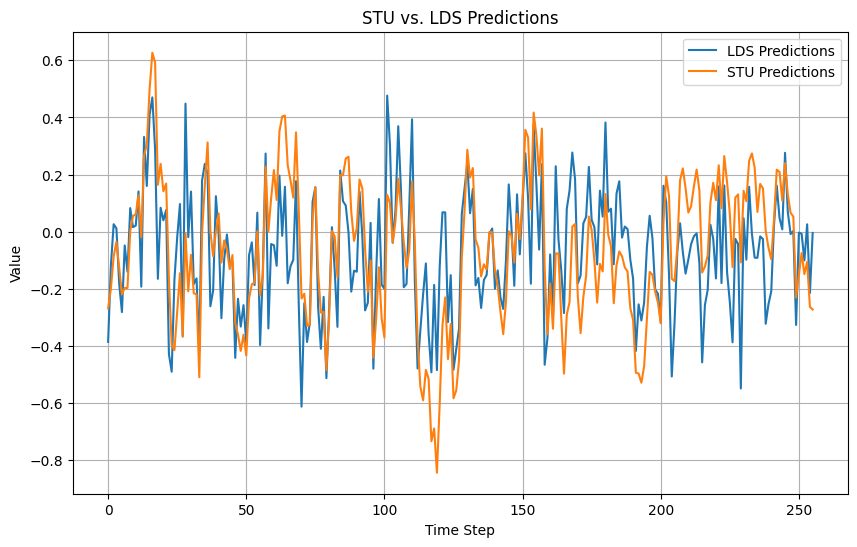

In [89]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lds_trajectory_list[0], label='LDS Predictions')
plt.plot(learned_filters_output_list[0], label='STU Predictions')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('STU vs. LDS Predictions')
plt.legend()
plt.grid(True)
plt.show()

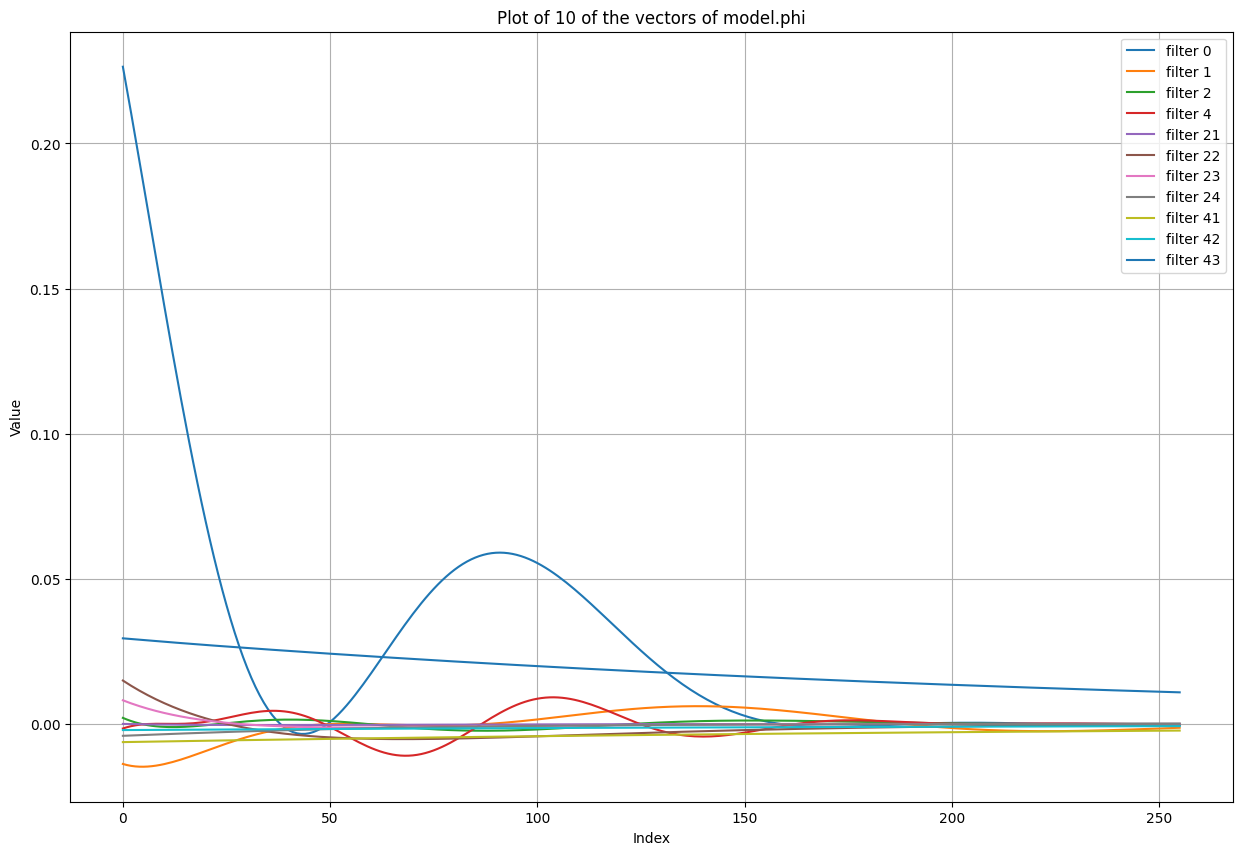

In [113]:
import matplotlib.pyplot as plt

# Plotting each of the 20 vectors
plt.figure(figsize=(15, 10))
for i in [0,1,2,4,21,22,23,24,41,42,43]:
	plt.plot(model.adaptive_filters()[i, :].cpu().detach().numpy(), label=f'filter {i}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of 10 of the vectors of model.phi')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
class STU(nn.Module):
    def __init__(self, config, phi) -> None:
        super(STU, self).__init__()
        self.config = config
        self.phi = phi
        self.n = nearest_power_of_two(config['seq_len'] * 2 - 1, round_up=True)
        self.K = config['num_eigh']
        self.d_in = config['d_in']
        self.d_out = config['d_out']
        self.use_hankel_L = config['use_hankel_L']
        self.use_approx = False
        self.M_phi_plus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

        self.M_phi_minus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Convolve inputs and filters,
        U_plus, U_minus = convolve(x, self.phi, self.n, False)
        # Then, contract over the K and d_in dimensions

        # print(U_plus.shape, U_minus.shape)
        spectral_plus = torch.tensordot(
            U_plus, self.M_phi_plus, dims=([2, 3], [0, 1])
        )

        spectral_minus = torch.tensordot(
            U_minus, self.M_phi_minus, dims=([2, 3], [0, 1])
        )

        # print(spectral_plus.shape)

        return spectral_plus if self.use_hankel_L else spectral_plus + spectral_minus

    def loss(self, inputs, targets):
        pred = self.forward(inputs)
        # print(pred, targets)
        loss = F.mse_loss(pred, targets)
        return  loss



In [101]:
import copy
class LDS:
  def __init__(self, A: torch.tensor, B: torch.tensor, C: torch.tensor, D: torch.tensor, h0: torch.tensor):
    self.d_h = A.shape
    _, self.d_u = B.shape
    self.d_o, _ = C.shape
    self.A = A  # hidden state dynamics
    self.B = B  # hidden state dynamics
    self.C = C  # observation projection
    self.D = D  # observation projection
    self.h0 = h0  # initial hidden state
    self.h = h0  # current hidden state
    self.dtype = float

  def step(self, u: torch.tensor) -> torch.tensor:
    assert u.shape == (self.d_u,)
    h_next = self.A @ self.h + self.B @ u
    obs = self.C @ h_next + self.D @ u
    self.h = h_next
    assert obs.shape == (self.d_o,)
    return obs

  def reset(self):
    self.h = self.h0
    return self

  def generate_trajectory(self, us: torch.tensor, h0: torch.tensor = None, return_hidden_state = False) -> torch.tensor:
    if h0 is not None:
      self.h = h0
    _, d_u = us.shape
    assert d_u == self.d_u, (d_u, self.d_u)
    obs = []
    hds = []
    h0 = copy.copy(self.h0)
    for u in us:
      obs.append(self.step(u))
      if return_hidden_state:
        hds.append(copy.copy(self.h))

    if return_hidden_state:
      return torch.stack(obs, dim = 0), torch.stack(hds, dim = 0), h0
    return torch.stack(obs, dim=0)

def random_LDS_single(d_h: int, d_o: int, d_u: int, delta: float):
  """
  makes a random LDS with hidden state dimension d_h, observation dimension d_o, and control dimension d_u.
  `delta` is a float in [0, 1] such that ||A|| = 1 - delta.
  """

  A = torch.randn(d_h, d_h)/d_h
  evals=torch.linalg.eigvals(A)
  max_eval=torch.max(torch.abs(evals)).item()
  A = (1-delta) * A/max_eval
  B = torch.rand(d_h, d_u) /d_u #torch.randn is normal distribution and leads to collapse  sometimes (idk why)
  C = torch.rand(d_o, d_h) / d_h
  D = torch.zeros(d_o, d_u)
  h0 = torch.zeros(d_h)
  return LDS(A.to(device), B.to(device), C.to(device), D.to(device), h0.to(device))

In [102]:
lds_test = random_LDS_single(d_h = d_h, d_o = d_out, d_u = d_in,delta =0.01)

In [78]:
config

{'num_eigh': 15,
 'num_fixed_filters': 0,
 'fixed_filters': tensor([[        nan,         nan,  0.0000e+00,  ..., -6.8317e-02,
          -1.3953e-17,  1.0097e+00],
         [        nan,         nan,  4.5683e-15,  ..., -5.0661e-17,
           5.9939e-01,  0.0000e+00],
         [        nan,         nan,  2.7126e-14,  ...,  3.5548e-01,
           1.0814e-16,  1.4927e-01],
         ...,
         [        nan,         nan, -1.7567e-06,  ..., -2.2621e-18,
           2.3569e-03,  1.1978e-21],
         [        nan,         nan, -6.1987e-08,  ...,  5.9962e-03,
          -2.9925e-17,  4.9118e-04],
         [        nan,         nan,  2.7667e-07,  ..., -1.9730e-18,
           1.9877e-03,  9.8619e-22]], device='cuda:0'),
 'use_hankel_L': True,
 'torch_dtype': torch.float32,
 'd_in': 1,
 'd_out': 1,
 'seq_len': 32,
 'task_count': 50000}

In [103]:
STU_Adaptive = STU(config, model.adaptive_filters().detach().T).to(device)
optimizer1 = torch.optim.Adam(STU_Adaptive.parameters(), lr=0.01)


spectral_phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)

STU_Fixed = STU(config, spectral_phi).to(device) # Use adaptive filters from the trained model
optimizer2 = torch.optim.Adam(STU_Fixed.parameters(), lr=0.01)

epochs = 1000

for it in range(epochs):
    inputs = torch.randn(seq_len, d_in).to(device)
    targets = lds_test.generate_trajectory(inputs)
    inputs = inputs.reshape(1, seq_len,  d_in)

    loss1 = STU_Adaptive.loss(inputs, targets)
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

    loss2 = STU_Fixed.loss(inputs, targets)
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

    if it % 100 == 0:
        print(f"Iteration {it}: STU Adaptive Loss = {loss1.item()}, STU Fixed Loss = {loss2.item()}")


STU_Adaptive.eval()
STU_Fixed.eval()

with torch.no_grad():
  test_input = torch.randn(1,seq_len, d_in).to(device)
  output1 = STU_Adaptive(test_input)
  output2 = STU_Fixed(test_input)

  test_input = test_input.reshape(seq_len, d_in)
  error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
  error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


print(f"Model 1 Error: {error1.item()}")
print(f"Model 2 Error: {error2.item()}")

<ipython-input-75-a375e9f7a32e>:42: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, targets)


Iteration 0: STU Adaptive Loss = 0.850488543510437, STU Fixed Loss = 0.6491986513137817
Iteration 100: STU Adaptive Loss = 0.10503028333187103, STU Fixed Loss = 0.06636644899845123
Iteration 200: STU Adaptive Loss = 0.09385152906179428, STU Fixed Loss = 0.06635085493326187
Iteration 300: STU Adaptive Loss = 0.06796696037054062, STU Fixed Loss = 0.007366314996033907
Iteration 400: STU Adaptive Loss = 0.09650061279535294, STU Fixed Loss = 0.044690802693367004
Iteration 500: STU Adaptive Loss = 0.06877031177282333, STU Fixed Loss = 0.014961380511522293
Iteration 600: STU Adaptive Loss = 0.3223560154438019, STU Fixed Loss = 0.30949336290359497
Iteration 700: STU Adaptive Loss = 0.07923173904418945, STU Fixed Loss = 0.028588535264134407
Iteration 800: STU Adaptive Loss = 0.2784444987773895, STU Fixed Loss = 0.23118650913238525
Iteration 900: STU Adaptive Loss = 0.05996793508529663, STU Fixed Loss = 0.0013054002774879336
Model 1 Error: 0.10965228080749512
Model 2 Error: 0.009828552603721619


<ipython-input-103-165dfce736fe>:43: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
<ipython-input-103-165dfce736fe>:44: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


In [105]:
def compare(k):
  accum  = 0
  for i in range(k):
    lds_test = random_LDS_single(d_h = d_h, d_o = d_out, d_u = d_in,delta =0.01)
    STU_Adaptive = STU(config, model.adaptive_filters().detach().T).to(device)
    optimizer1 = torch.optim.Adam(STU_Adaptive.parameters(), lr=0.01)


    spectral_phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L,
                                    device  = device,  dtype = torch.float32)
    STU_Fixed = STU(config, spectral_phi).to(device) # Use adaptive filters from the trained model
    optimizer2 = torch.optim.Adam(STU_Fixed.parameters(), lr=0.01)

    epochs = 1001

    for it in range(epochs):
        inputs = torch.randn(seq_len, d_in).to(device)
        targets = lds_test.generate_trajectory(inputs)
        inputs = inputs.reshape(1, seq_len,  d_in)

        loss1 = STU_Adaptive.loss(inputs, targets)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        loss2 = STU_Fixed.loss(inputs, targets)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        if it % 1000 == 0:
            print(f"Iteration {it}: STU Adaptive Loss = {loss1.item()}, STU Fixed Loss = {loss2.item()}")


    STU_Adaptive.eval()
    STU_Fixed.eval()

    with torch.no_grad():
      test_input = torch.randn(1,seq_len, d_in).to(device)
      output1 = STU_Adaptive(test_input)
      output2 = STU_Fixed(test_input)

      test_input = test_input.reshape(seq_len, d_in)
      error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
      error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


    print(f"Model 1 and 2 Error: {error1.item():.4f}, {error2.item():.4f}")

    if error1.item() < error2.item():
      accum  +=1
  print(f"Win Rate: {accum/k}")

In [106]:
compare(20)

<ipython-input-75-a375e9f7a32e>:42: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, targets)


Iteration 0: STU Adaptive Loss = 0.21154451370239258, STU Fixed Loss = 0.021607140079140663
Iteration 1000: STU Adaptive Loss = 0.0015723055694252253, STU Fixed Loss = 0.0003563674399629235
Model 1 and 2 Error: 0.0017, 0.0002
Iteration 0: STU Adaptive Loss = 1.6492056846618652, STU Fixed Loss = 1.4093518257141113


<ipython-input-105-16d751dbe1e7>:46: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
<ipython-input-105-16d751dbe1e7>:47: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


Iteration 1000: STU Adaptive Loss = 1.3872730731964111, STU Fixed Loss = 1.2119295597076416
Model 1 and 2 Error: 1.1336, 1.1196
Iteration 0: STU Adaptive Loss = 3.8754196166992188, STU Fixed Loss = 3.7429709434509277
Iteration 1000: STU Adaptive Loss = 2.5553855895996094, STU Fixed Loss = 0.44021159410476685
Model 1 and 2 Error: 1.8046, 0.0061
Iteration 0: STU Adaptive Loss = 1.1425668001174927, STU Fixed Loss = 1.1120929718017578
Iteration 1000: STU Adaptive Loss = 1.7524365186691284, STU Fixed Loss = 0.07195758074522018
Model 1 and 2 Error: 0.9602, 0.5206
Iteration 0: STU Adaptive Loss = 0.5418229103088379, STU Fixed Loss = 0.39664584398269653
Iteration 1000: STU Adaptive Loss = 0.2882406413555145, STU Fixed Loss = 0.05448130518198013
Model 1 and 2 Error: 0.2686, 0.0079
Iteration 0: STU Adaptive Loss = 4.201513767242432, STU Fixed Loss = 0.7783831357955933
Iteration 1000: STU Adaptive Loss = 0.016936998814344406, STU Fixed Loss = 0.007863313890993595
Model 1 and 2 Error: 0.0152, 0.07

In [135]:
config['num_eigh'] = 60

In [132]:
adaptive_filters.shape

torch.Size([256, 120])

In [133]:
spectral_phi= get_spectral_filters(seq_len = seq_len, K = 30,  use_hankel_L= use_hankel_L,
                                    device  = device,  dtype = torch.float32)

In [ ]:
adaptive_filters = torch.concat([model.adaptive_filters()[:30].detach().T/50, spectral_phi], axis =  -1)

STU_Adaptive = STU(config, adaptive_filters).to(device)
optimizer1 = torch.optim.Adam(STU_Adaptive.parameters(), lr=0.01)


spectral_phi_doubled= get_spectral_filters(seq_len = seq_len, K = 60,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)

STU_Fixed = STU(config, spectral_phi_doubled).to(device)
optimizer2 = torch.optim.Adam(STU_Fixed.parameters(), lr=0.01)

epochs = 1000

for it in range(epochs):
    inputs = torch.randn(seq_len, d_in).to(device)
    targets = lds_test.generate_trajectory(inputs)
    inputs = inputs.reshape(1, seq_len,  d_in)

    loss1 = STU_Adaptive.loss(inputs, targets)
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

    loss2 = STU_Fixed.loss(inputs, targets)
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

    if it % 100 == 0:
        print(f"Iteration {it}: STU Adaptive Loss = {loss1.item()}, STU Fixed Loss = {loss2.item()}")

STU_Adaptive.eval()
STU_Fixed.eval()

with torch.no_grad():
  test_input = torch.randn(1,seq_len, d_in).to(device)
  output1 = STU_Adaptive(test_input)  
  output2 = STU_Fixed(test_input)  

  test_input = test_input.reshape(seq_len, d_in)
  error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
  error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


print(f"Model 1 Error: {error1.item()}")
print(f"Model 2 Error: {error2.item()}")

<ipython-input-75-a375e9f7a32e>:42: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, targets)


Iteration 0: STU Adaptive Loss = 0.28693699836730957, STU Fixed Loss = 0.1845141053199768
Iteration 100: STU Adaptive Loss = 0.2568064033985138, STU Fixed Loss = 0.2817603349685669
Iteration 200: STU Adaptive Loss = 0.06831824779510498, STU Fixed Loss = 0.06822146475315094
Iteration 300: STU Adaptive Loss = 0.1677599847316742, STU Fixed Loss = 0.18240846693515778
Iteration 400: STU Adaptive Loss = 0.011131822131574154, STU Fixed Loss = 0.010885567404329777
Iteration 500: STU Adaptive Loss = 0.00608346052467823, STU Fixed Loss = 0.005896068178117275
Iteration 600: STU Adaptive Loss = 0.03924380615353584, STU Fixed Loss = 0.03937035799026489
Iteration 700: STU Adaptive Loss = 0.0072279735468328, STU Fixed Loss = 0.006852590478956699
Iteration 800: STU Adaptive Loss = 0.2410508692264557, STU Fixed Loss = 0.24092227220535278
Iteration 900: STU Adaptive Loss = 0.11849984526634216, STU Fixed Loss = 0.11981014162302017
Model 1 Error: 0.050009649246931076
Model 2 Error: 0.11272808909416199


<ipython-input-138-dbd7a9e7d801>:45: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
<ipython-input-138-dbd7a9e7d801>:46: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


In [ ]:
e1_list = []
e2_list = []
def compare_adapt(k):
  accum  = 0

  for i in range(k):
    adaptive_filters = torch.concat([model.adaptive_filters()[:30].detach().T, spectral_phi], axis =  -1)

    STU_Adaptive = STU(config, adaptive_filters).to(device)
    optimizer1 = torch.optim.Adam(STU_Adaptive.parameters(), lr=0.01)


    spectral_phi_doubled= get_spectral_filters(seq_len = seq_len, K = 60,  use_hankel_L= use_hankel_L,
                                    device  = device,  dtype = torch.float32)

    STU_Fixed = STU(config, spectral_phi_doubled).to(device)
    optimizer2 = torch.optim.Adam(STU_Fixed.parameters(), lr=0.01)

    epochs = 1000

    for it in range(epochs):
        inputs = torch.randn(seq_len, d_in).to(device)
        targets = lds_test.generate_trajectory(inputs)
        inputs = inputs.reshape(1, seq_len,  d_in)
 
        loss1 = STU_Adaptive.loss(inputs, targets)
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()

        loss2 = STU_Fixed.loss(inputs, targets)
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()

        if it % 100 == 0:
            print(f"Iteration {it}: STU Adaptive Loss = {loss1.item()}, STU Fixed Loss = {loss2.item()}")



    STU_Adaptive.eval()
    STU_Fixed.eval()

    with torch.no_grad():
      test_input = torch.randn(1,seq_len, d_in).to(device)
      output1 = STU_Adaptive(test_input)  
      output2 = STU_Fixed(test_input)  

      test_input = test_input.reshape(seq_len, d_in)
      error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
      error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


    print(f"Model 1 Error: {error1.item()}")
    print(f"Model 2 Error: {error2.item()}")
    e1_list.append(error1.item())
    e2_list.append(error2.item())
    if error1.item() < error2.item():
      accum  +=1
  print(f"Win Rate: {accum/k}")

In [144]:
compare_adapt(20)

<ipython-input-75-a375e9f7a32e>:42: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, targets)


Iteration 0: STU Adaptive Loss = 0.8652485013008118, STU Fixed Loss = 0.8167310953140259
Iteration 100: STU Adaptive Loss = 0.009148676879703999, STU Fixed Loss = 0.02055853232741356
Iteration 200: STU Adaptive Loss = 0.03548882156610489, STU Fixed Loss = 0.046664804220199585
Iteration 300: STU Adaptive Loss = 0.0033185328356921673, STU Fixed Loss = 0.002571424935013056
Iteration 400: STU Adaptive Loss = 0.035231273621320724, STU Fixed Loss = 0.05604400485754013
Iteration 500: STU Adaptive Loss = 0.12166283279657364, STU Fixed Loss = 0.12714949250221252
Iteration 600: STU Adaptive Loss = 0.16978847980499268, STU Fixed Loss = 0.16912204027175903
Iteration 700: STU Adaptive Loss = 0.3180392384529114, STU Fixed Loss = 0.3123866319656372
Iteration 800: STU Adaptive Loss = 0.4587189257144928, STU Fixed Loss = 0.4592764377593994
Iteration 900: STU Adaptive Loss = 0.037477344274520874, STU Fixed Loss = 0.041487716138362885


<ipython-input-143-1ed1fbc6f647>:51: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error1 = F.mse_loss(output1, lds_test.generate_trajectory(test_input))
<ipython-input-143-1ed1fbc6f647>:52: UserWarning: Using a target size (torch.Size([256, 1])) that is different to the input size (torch.Size([1, 256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  error2 = F.mse_loss(output2, lds_test.generate_trajectory(test_input))


Model 1 Error: 0.04982166737318039
Model 2 Error: 0.047576162964105606
Iteration 0: STU Adaptive Loss = 0.7743091583251953, STU Fixed Loss = 0.542367696762085
Iteration 100: STU Adaptive Loss = 0.0025316178798675537, STU Fixed Loss = 0.036863312125205994
Iteration 200: STU Adaptive Loss = 0.005712213926017284, STU Fixed Loss = 0.019634848460555077
Iteration 300: STU Adaptive Loss = 0.023428983986377716, STU Fixed Loss = 0.016043081879615784
Iteration 400: STU Adaptive Loss = 0.007979093119502068, STU Fixed Loss = 0.0070731379091739655
Iteration 500: STU Adaptive Loss = 0.051796555519104004, STU Fixed Loss = 0.04982827603816986
Iteration 600: STU Adaptive Loss = 0.014479664154350758, STU Fixed Loss = 0.01434768084436655
Iteration 700: STU Adaptive Loss = 0.15900292992591858, STU Fixed Loss = 0.15223073959350586
Iteration 800: STU Adaptive Loss = 0.48130446672439575, STU Fixed Loss = 0.4764125645160675
Iteration 900: STU Adaptive Loss = 0.004483542870730162, STU Fixed Loss = 0.0017324273

In [ ]:
mse_e1 = np.mean(np.array(e1_list))
mse_e2 = np.mean(np.array(e2_list))

print(f"Average MSE for e1_list: {mse_e1}")
print(f"Average MSE for e2_list: {mse_e2}")

Average MSE for e1_list: 0.10774652594700455
Average MSE for e2_list: 0.1119439201138448
